In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import tqdm
import skimage.transform
from sklearn.model_selection import train_test_split

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
def read_pictures(directory='train/'):
    with open('files_list.txt') as f:
        files_list = f.readlines()
    files_list = [(directory+i.strip()) for i in files_list]
    return files_list

In [3]:
input_shape = (128, 128, 1)
# files_list = read_pictures('preprocessed_images/')
files_list = read_pictures()

In [4]:
def preprocess_img(img):
    return skimage.transform.resize(img, input_shape)

In [21]:
def get_dataset(preprocess = True):
    X = []
    y = []
    for i in tqdm.tqdm(files_list):
        if preprocess:
            X.append(preprocess_img(plt.imread(i)))
        else:
            X.append(plt.imread(i))
            
        if 'cat' in i:
            y.append([1, 0])
        else:
            y.append([0, 1])
    return X, y

In [6]:
def save_preprocessed_images(images):
    for i, name in tqdm.tqdm(zip(images, files_list)):
        plt.imsave(f'preprocessed_images/{name.split("/")[-1]}', i)

In [22]:
X, y = get_dataset(preprocess=True)

  0%|                                        | 0/25000 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
100%|████████████████████████████| 25000/25000 [07:15<00:00, 57.43it/s]


In [16]:
save_preprocessed_images(X)

0it [00:00, ?it/s]


ValueError: Invalid dimensions, got (128, 128, 1)

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

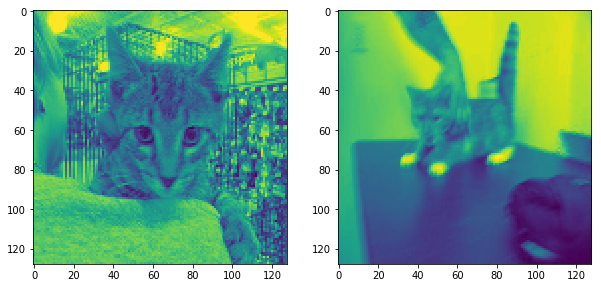

In [24]:
plt.figure(figsize=(10,10))
plt.subplot(121)
plt.imshow(X[502][:,:,0]);
plt.subplot(122)
plt.imshow(X[0][:,:,0])
plt.show()

In [25]:
def inference(inp):
    with tf.name_scope('classificator'):
        with tf.name_scope('convolution'):
            layer = tf.layers.conv2d(inp, 32, 3, activation=tf.nn.relu)
            layer = tf.layers.max_pooling2d(layer, pool_size=3, strides=2)
            layer = tf.layers.conv2d(layer, 64, 3, activation=tf.nn.relu)
            layer = tf.layers.max_pooling2d(layer, pool_size=3, strides=2)
            layer = tf.layers.conv2d(layer, 64, 3, activation=tf.nn.relu)
            layer = tf.nn.dropout(layer, .5)
            layer = tf.layers.max_pooling2d(layer, pool_size=3, strides=2)
            layer = tf.layers.conv2d(layer, 64, 3, activation=tf.nn.relu)
            layer = tf.layers.max_pooling2d(layer, pool_size=3, strides=2)
#             layer = tf.layers.conv2d(layer, 32, 5, activation=tf.nn.relu)
#             layer = tf.layers.max_pooling2d(layer, pool_size=3, strides=2)
#             layer = tf.layers.conv2d(layer, 16, 5, activation=tf.nn.relu)
#             layer = tf.layers.max_pooling2d(layer, pool_size=3, strides=2)
            layer = tf.layers.flatten(layer)

        with tf.name_scope('dense'):
            layer = tf.layers.dense(layer, 1024, activation=tf.nn.relu)
            layer = tf.nn.dropout(layer, .5)
            layer = tf.layers.dense(layer, 512, activation=tf.nn.relu)
#             layer = tf.layers.dense(layer, 128, activation=tf.nn.relu)
            layer = tf.layers.dense(layer, 2, activation=tf.nn.softmax)
            
    return layer

In [47]:
def training(sess, X_train, y_train, X_test, y_test, epochs=100, batch_size=64):
    with tf.name_scope('network_input'):
        x_input = tf.placeholder(tf.float32, shape=(None, *input_shape), name='features')
        y_input = tf.placeholder(tf.float32, shape=(None, 2))
    
    with tf.variable_scope('cnn', reuse=tf.AUTO_REUSE):
        outputs = inference(x_input)
        logits = tf.nn.softmax(outputs, name='output')
    
    with tf.name_scope('training'):
        loss = tf.reduce_mean(tf.losses.softmax_cross_entropy(onehot_labels=y_input, logits=outputs))
        optimize = tf.train.AdamOptimizer().minimize(loss)
        
    with tf.name_scope('accuracy_measurement'):
        accuracy, acc_update = tf.metrics.accuracy(y_input, logits)
        
    sess.run([tf.global_variables_initializer(), tf.local_variables_initializer()])
    saver = tf.train.Saver()
    train_writer = tf.summary.FileWriter('logs/', sess.graph)
    
    for i in range(epochs):
        for j in tqdm.trange(int(len(X_train)/batch_size)):
            point = j*batch_size
            ls, _, answ = sess.run([loss, optimize, logits], feed_dict={x_input: X_train[point:point+batch_size], y_input: y_train[point:point+batch_size]})
        
        if i%1==0:
            acc = get_accuracy(X_test, y_test)
            acc_train = 1-np.sum(np.logical_xor(np.asarray(y_train)[point:point+batch_size, 0], np.round(answ)[:,0]))/batch_size
            print(f'Test accuracy: {int(acc*100)}% \tTraining loss: {ls} \t Training accuracy: {acc_train}')

In [27]:
def predict(sess, img):
    x_input = tf.placeholder(tf.float32, shape=(None, *input_shape))
    with tf.variable_scope('cnn', reuse=tf.AUTO_REUSE):
        outputs = inference(x_input)
        logits = tf.nn.softmax(outputs)
    
    return sess.run(logits, feed_dict={x_input: img})[:, 0]

In [31]:
def get_accuracy(X_test, y_test, batch_size=128):
    res=[]
    for j in range(int(len(X_test)/batch_size)+1):
        point = j*batch_size
        res.extend(predict(sess, X_test[point:point+batch_size]))
    
    return 1-np.sum(np.logical_xor(np.asarray(y_test)[:,0], np.round(res)))/len(X_test)

In [48]:
tf.reset_default_graph()
sess = tf.Session()
training(sess, X_train, y_train, X_test, y_test, batch_size=128, epochs=5)
print(predict(sess, [X[0]]))



  0%|                                          | 0/136 [00:00<?, ?it/s]

  1%|▎                                 | 1/136 [00:00<00:24,  5.49it/s]

  2%|▊                                 | 3/136 [00:00<00:12, 10.56it/s]

  4%|█▎                                | 5/136 [00:00<00:10, 12.99it/s]

  5%|█▊                                | 7/136 [00:00<00:09, 14.26it/s]

  7%|██▎                               | 9/136 [00:00<00:08, 15.23it/s]

  8%|██▋                              | 11/136 [00:00<00:07, 15.74it/s]

 10%|███▍                             | 14/136 [00:00<00:07, 16.55it/s]

 12%|███▉                             | 16/136 [00:00<00:07, 16.91it/s]

 14%|████▌                            | 19/136 [00:01<00:06, 17.48it/s]

 15%|█████                            | 21/136 [00:01<00:06, 17.68it/s]

 18%|█████▊                           | 24/136 [00:01<00:06, 18.05it/s]

 19%|██████▎                          | 26/136 [00:01<00:06, 18.14it/s]

 21%|██████▊                          | 28/136 [0

Test accuracy: 65% 	Training loss: 0.6263469457626343 	 Training accuracy: 0.671875




  0%|                                          | 0/136 [00:00<?, ?it/s]

  2%|▊                                 | 3/136 [00:00<00:06, 20.98it/s]

  4%|█▎                                | 5/136 [00:00<00:06, 20.49it/s]

  6%|██                                | 8/136 [00:00<00:06, 20.78it/s]

  7%|██▍                              | 10/136 [00:00<00:06, 20.62it/s]

 10%|███▏                             | 13/136 [00:00<00:05, 20.70it/s]

 11%|███▋                             | 15/136 [00:00<00:05, 20.58it/s]

 12%|████▏                            | 17/136 [00:00<00:05, 20.48it/s]

 15%|████▊                            | 20/136 [00:00<00:05, 20.56it/s]

 16%|█████▎                           | 22/136 [00:01<00:05, 20.47it/s]

 18%|█████▊                           | 24/136 [00:01<00:05, 20.44it/s]

 19%|██████▎                          | 26/136 [00:01<00:05, 20.38it/s]

 21%|███████                          | 29/136 [00:01<00:05, 20.44it/s]

 24%|███████▊                         | 32/136 [0

Test accuracy: 70% 	Training loss: 0.5775898098945618 	 Training accuracy: 0.7265625




  0%|                                          | 0/136 [00:00<?, ?it/s]

  1%|▌                                 | 2/136 [00:00<00:07, 18.69it/s]

  3%|█                                 | 4/136 [00:00<00:06, 18.87it/s]

  4%|█▌                                | 6/136 [00:00<00:06, 19.23it/s]

  6%|██                                | 8/136 [00:00<00:06, 19.32it/s]

  7%|██▍                              | 10/136 [00:00<00:06, 19.42it/s]

  9%|██▉                              | 12/136 [00:00<00:06, 19.54it/s]

 11%|███▋                             | 15/136 [00:00<00:06, 19.87it/s]

 13%|████▎                            | 18/136 [00:00<00:05, 20.07it/s]

 15%|████▊                            | 20/136 [00:01<00:05, 19.98it/s]

 17%|█████▌                           | 23/136 [00:01<00:05, 20.19it/s]

 18%|██████                           | 25/136 [00:01<00:05, 20.18it/s]

 20%|██████▌                          | 27/136 [00:01<00:05, 20.09it/s]

 21%|███████                          | 29/136 [0

Test accuracy: 75% 	Training loss: 0.5351763963699341 	 Training accuracy: 0.75




  0%|                                          | 0/136 [00:00<?, ?it/s]

  1%|▌                                 | 2/136 [00:00<00:07, 18.52it/s]

  3%|█                                 | 4/136 [00:00<00:06, 18.87it/s]

  4%|█▌                                | 6/136 [00:00<00:06, 19.05it/s]

  6%|██                                | 8/136 [00:00<00:06, 19.14it/s]

  7%|██▍                              | 10/136 [00:00<00:06, 19.42it/s]

 10%|███▏                             | 13/136 [00:00<00:06, 19.73it/s]

 11%|███▋                             | 15/136 [00:00<00:06, 19.69it/s]

 13%|████▎                            | 18/136 [00:00<00:05, 19.98it/s]

 15%|████▊                            | 20/136 [00:01<00:05, 19.92it/s]

 17%|█████▌                           | 23/136 [00:01<00:05, 20.05it/s]

 19%|██████▎                          | 26/136 [00:01<00:05, 20.11it/s]

 21%|███████                          | 29/136 [00:01<00:05, 20.21it/s]

 24%|███████▊                         | 32/136 [0

Test accuracy: 79% 	Training loss: 0.47771209478378296 	 Training accuracy: 0.828125




  0%|                                          | 0/136 [00:00<?, ?it/s]

  1%|▌                                 | 2/136 [00:00<00:07, 18.01it/s]

  3%|█                                 | 4/136 [00:00<00:07, 18.43it/s]

  4%|█▌                                | 6/136 [00:00<00:06, 18.99it/s]

  6%|██                                | 8/136 [00:00<00:06, 19.00it/s]

  7%|██▍                              | 10/136 [00:00<00:06, 19.27it/s]

  9%|██▉                              | 12/136 [00:00<00:06, 19.35it/s]

 10%|███▍                             | 14/136 [00:00<00:06, 19.39it/s]

 12%|████▏                            | 17/136 [00:00<00:06, 19.68it/s]

 14%|████▌                            | 19/136 [00:00<00:05, 19.60it/s]

 16%|█████▎                           | 22/136 [00:01<00:05, 19.81it/s]

 18%|█████▊                           | 24/136 [00:01<00:05, 19.84it/s]

 19%|██████▎                          | 26/136 [00:01<00:05, 19.81it/s]

 21%|███████                          | 29/136 [0

Test accuracy: 79% 	Training loss: 0.5105196833610535 	 Training accuracy: 0.8046875
[0.47545362]


In [49]:
saver = tf.train.Saver()
saver.save(sess, 'saved_model/classifier.ckpt')

'saved_model/classifier.ckpt'

In [18]:
_, a = get_accuracy(X_test, y_test)

In [30]:
print(np.asarray(y_test)[:,0])
# print(a)

[1 0 0 ... 0 1 1]


In [ ]:
graph = tf.get_default_graph()
test_image = skimage.transform.resize(plt.imread('train/cat.0.jpg'), (128,128,3))
x = graph.get_tensor_by_name('network_input/features:0')
y = graph.get_tensor_by_name('cnn/output:0')
sess.run(y, feed_dict={x: [test_image]})